In [1]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

# 난수 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

### 데이터셋 작성

In [10]:
# 입력 화상의 전처리 클래스
# 훈련 시와 추론 시 처리가 다르다.

class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase='train'):
        # phase : 'train' or 'val'
        return self.data_transform[phase](img)

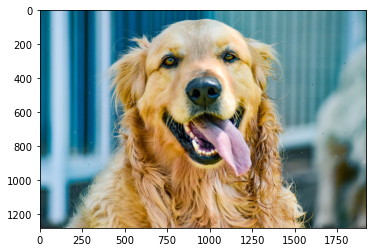

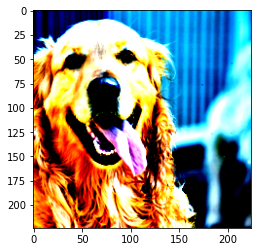

In [12]:
# 훈련 시 화상 전처리 동작 확인
# 실행할 때마다 처리 결과 화상이 바뀐다.

# 1. 화상 읽기
image_file_path = './data/goldenretriever-3724972_1920.jpg'
img = Image.open(image_file_path) #[높이][폭][RGB]
plt.imshow(img)
plt.show()

# 화상 전처리, 처리된 화상 표시
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img)

# (색상, 높이, 너비) 를 (높이, 너비, 색상) 으로 변경하고 0-1로 값을 제한해 표시
img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()


In [21]:
# 개미와 벌이 담긴 화상 파일의 경로 리스트 작성
def make_datapath_list(phase='train'):
    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)
    
    path_list = [] # 여기에 저장
    
    # glob를 이용하여 하위 디렉토리의 파일 경로를 가져온다.
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list


# 실행
train_list = make_datapath_list('train')
val_list = make_datapath_list('val')

train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train/bees/2445215254_51698ff797.jpg',
 './data/hymenoptera_data/train/bees/760568592_45a52c847f.jpg',
 './data/hymenoptera_data/train/bees/2358061370_9daabbd9ac.jpg',
 './data/hymenoptera_data/train/bees/2397446847_04ef3cd3e1.jpg',
 './data/hymenoptera_data/train/bees/873076652_eb098dab2d.jpg',
 './data/hymenoptera_data/train/bees/452462695_40a4e5b559.jpg',
 './data/hymenoptera_data/train/bees/2756397428_1d82a08807.jpg',
 './data/hymenoptera_data/train/bees/3044402684_3853071a87.jpg',
 './data/hymenoptera_data/train/bees/969455125_58c797ef17.jpg',
 './data/hymenoptera_data/train/bees/2638074627_6b3ae746a0.jpg',
 './data/hymenoptera_data/train/bees/2601176055_8464e6aa71.jpg',
 './data/hymenoptera_data/train/bees/196430254_46bd129ae7.jpg',
 './data/hymenoptera_data/train/bees/452462677_7be43af8ff.jpg',
 './data/hymenoptera_data/train/bees/2384149906_2cd8b0b699.jpg',
 './data/hymenoptera_data/train/bees/3030189811_01d095b793.jpg',
 './data/hymenoptera_data/train

In [22]:
# 개미와 벌의 화상에 대한 Dataset 작성
class HymenopteraDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list # 파일경로 리스트
        self.transform = transform # 전처리 클래스의 인스턴스
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        # 전처리 한 화상의 텐서 형식의 데이터와 라벨 취득
        
        # index번째의 화상 로드
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        
        if self.phase == 'train':
            label = img_path[30:34]
        elif self.phase == 'val':
            label = img_path[28:32]
            
        # 라벨을 숫자로 변경
        if label == 'ants':
            label = 0
        elif label == 'bees':
            label = 1
            
        return img_transformed, label
        

In [23]:
train_dataset = HymenopteraDataset(file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = HymenopteraDataset(file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
1


### 데이터 로더 작성

In [24]:
# 미니배치 크기 지정
batch_size = 32

# 데이터 로더 작성
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["train"]) # iterator로 변환
inputs, labels = next(batch_iterator) # 첫 번째 요소 추출
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 1, 1])


### 네트워크 모델 작성

In [27]:
# VGG-16 모델의 인스턴스 생성
use_pretrained = True # 학습된 파라미터 사용
net = models.vgg16(pretrained=use_pretrained)

# VGG의 마지막 출력층의 출력 유닛을 개미와 벌인 두 개로 변경 (전결합 층)
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 훈련 모드로 설정
net.train()

print('네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.')

네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.


### 손실함수 정의

In [28]:
criterion = nn.CrossEntropyLoss()

### 최적화 기법 설정

In [29]:
# 전이학습에서 학습시킬 파라미터를 params_to_update 변수에 저장
params_to_update = []

# 학습시킬 파라미터 이름
update_param_names = ['classifier.6.weight', 'classifier.6.bias']

# 학습시킬 파라미터 외에는 경사를 계산하지 않고 변하지 않도록 설정
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False
        
# params_to_update의 내용 확인
print('-----------------')
print(params_to_update)

classifier.6.weight
classifier.6.bias
-----------------
[Parameter containing:
tensor([[ 0.0092,  0.0147,  0.0002,  ..., -0.0072, -0.0123, -0.0056],
        [ 0.0147,  0.0119, -0.0059,  ..., -0.0062,  0.0033,  0.0096]],
       requires_grad=True), Parameter containing:
tensor([-0.0102, -0.0133], requires_grad=True)]


In [31]:
# 최적화 기법 설정
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

### 학습 및 검증 실시

In [34]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    # 에폭 루프
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('--------------------------------')
        
        # 에폭별 학습 및 검증 루프
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0 # 에폭 손실 합
            epoch_corrects = 0 # 에폭 정답 수
            
            # 학습하지 않을 시 검증 성능을 확인하기 위해 epoch=0의 훈련은 생략
            if (epoch==0) and (phase=='train'):
                continue
                
            # 데이터로더로 미니 배치를 꺼내는 루프
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad()
                
                # 순전파 계산
                with torch.set_grad_enabled(phase=='train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    # 훈련시에는 오차 역전파
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    # 반복 결과 계산
                    # 손실 합계 갱신
                    epoch_loss += loss.item()*inputs.size(0)
                    # 정답 수의 합계 갱신
                    epoch_corrects += torch.sum(preds==labels.data)
                    
            # 에폭당 손실과 정답률 표시
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [35]:
# 학습 및 검증 실시
num_epochs = 3
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs)

Epoch 1/3
--------------------------------


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


val Loss: 0.7056 Acc: 0.5294
Epoch 2/3
--------------------------------


100%|██████████| 8/8 [00:21<00:00,  2.64s/it]


train Loss: 0.4742 Acc: 0.7778


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


val Loss: 0.1749 Acc: 0.9412
Epoch 3/3
--------------------------------


100%|██████████| 8/8 [00:20<00:00,  2.59s/it]


train Loss: 0.1456 Acc: 0.9424


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]

val Loss: 0.1165 Acc: 0.9412
